In [91]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


# Structure
- Pre-processing of data (data cleaning)  
- Consider long and lat data, import map libraries
- Section 1 (Distance, ave speed)
- Section 2 (Range of speed, which is faster)
    - suggestions: check first 10km, or last 10 km
- Section 3 (Compare time trial speed)
- Section 4 (consider elevation, descent, flat).


# Pre-processing of data

First, we combine all 4 datasets into one for faster access to data.  
Second, we add a column to indicate which type of dataset it is from.

In [4]:
# Combining datasets to prep data for plots

# Assign datasets to new variables with a new column indicating type of dataset

r16 = rr_2016.copy(deep=True)
r16['dataset'] = "2016 Race"

t16 = tt_2016.copy(deep=True)
t16['dataset'] = "2016 Time Trial"

r19 = rr_2019.copy(deep=True)
r19['dataset'] = "2019 Race"

t19 = tt_2019.copy(deep=True)
t19['dataset'] = "2019 Time Trial"

merge = [r16,t16,r19,t19]
df = pd.concat(merge)
df.sample(n=5)

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2019-06-23 00:05:14+00:00,-33.414965,151.221802,217.8,7.0,269.0,94.0,153.0,0.010840,0.0,39.024005,1.0,2019 Race
2019-06-01 23:20:57+00:00,-33.327510,151.231367,295.8,10.0,166.0,87.0,152.0,0.011456,-0.4,41.243287,1.0,2019 Time Trial
2019-06-01 23:30:18+00:00,-33.379195,151.225066,232.8,9.0,236.0,93.0,151.0,0.012199,-0.2,43.915552,1.0,2019 Time Trial
2016-05-14 05:18:59+00:00,-33.369439,151.228371,223.6,24.0,0.0,52.0,162.0,0.021921,0.0,39.458410,2.0,2016 Race
2019-06-22 22:37:15+00:00,-33.414091,151.221017,217.2,5.0,145.0,84.0,118.0,0.007972,0.0,28.699784,1.0,2019 Race


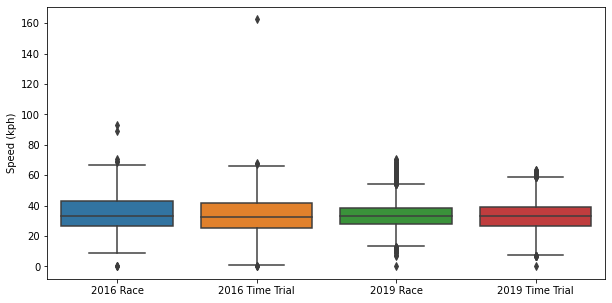

In [5]:
# Make boxplots for all datasets

plt.subplots(figsize=(10,5))
bx = sns.boxplot(x='dataset',y='speed',data=df)
bx.set(xlabel = '',ylabel="Speed (kph)")
plt.show()

### Initial thoughts

It seems that there's an obvious outlier in the __2016 Time Trial__. \
However, it is doubtful whether the __2016 Race's__ speeds above 80 are outliers or not.

So we examine if the speeds above 80 are outliers by seeing the relationship between __Elevation Gain__ and __Speed__. The hypothesis is that the high speeds are due to huge descent (negative elevations).

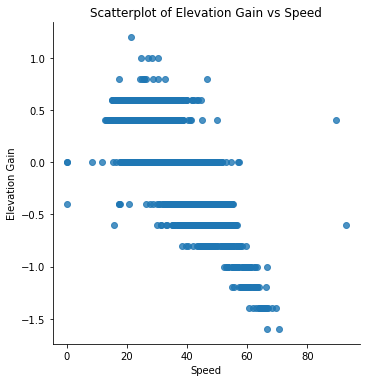

In [6]:
# Create scatterplot
ax = sns.lmplot(x='speed',
           y='elevation_gain',
          data=df.query('dataset=="2016 Race"'),
          fit_reg = False)

# Set labels
ax.set(xlabel='Speed',
       ylabel = "Elevation Gain",
      title = 'Scatterplot of Elevation Gain vs Speed')
plt.show(ax)

### Conclusion on speeds above 80

With positive elevation gains, which means the road is ascending, the speed ranges from about 15kph to 50kph. But there is one datapoint that is more than 80kph.

With negative elevation gains, which means the road is descending, the range of speed gets higher as the road tilts lower. However, there is still one weird data point that is more than 80kph.

Since the speeds above 80 seem far from the rest of datapoints, we can conclude that these are just erroneous data.
Instead of removing, these data will just need to be _smoothed out_  for the purpose of this analysis.

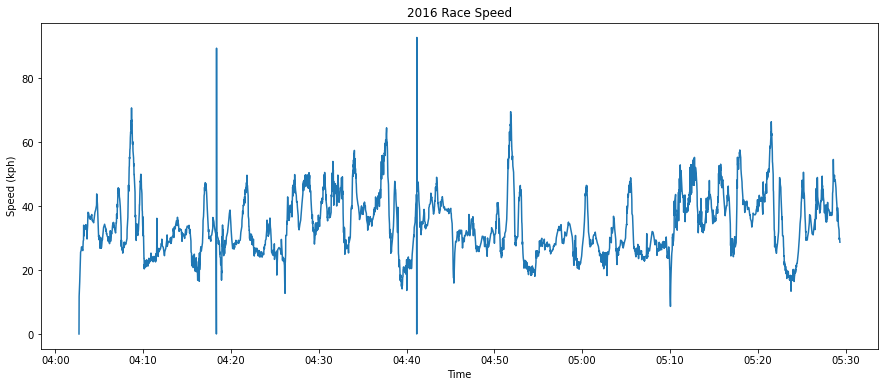

In [7]:
# Line plot of 2016 Race
plt.figure(figsize=(15,6))
ln = sns.lineplot(data=df.query('dataset == "2016 Race"'),
             x=df.query('dataset == "2016 Race"').index,
             y='speed')
ln.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ln.set(xlabel = 'Time', ylabel='Speed (kph)', title = '2016 Race Speed')
plt.show()

In [8]:
# What timestamp did we have a speed of more than 80?

gt80 = df.query('dataset=="2016 Race"')['speed'] > 80
gt80[gt80 == True]

2016-05-14 04:18:21+00:00    True
2016-05-14 04:41:10+00:00    True
Name: speed, dtype: bool

In [9]:
# Check the speeds a few seconds before and after the anomaly

df.query('dataset=="2016 Race"').between_time('4:18:12','4:18:23')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-05-14 04:18:12+00:00,-33.350962,151.229808,248.0,27.0,0.0,77.0,149.0,0.062203,0.0,31.990190,7.0,2016 Race
2016-05-14 04:18:18+00:00,-33.350502,151.229872,248.0,27.0,0.0,74.0,147.0,0.051494,0.0,30.896364,6.0,2016 Race
2016-05-14 04:18:20+00:00,-33.350502,151.229872,248.0,27.0,0.0,76.0,150.0,0.000000,0.0,0.000000,2.0,2016 Race
2016-05-14 04:18:21+00:00,-33.350280,151.229901,248.4,27.0,0.0,82.0,150.0,0.024832,0.4,89.394487,1.0,2016 Race
2016-05-14 04:18:22+00:00,-33.350204,151.229909,249.0,27.0,0.0,83.0,149.0,0.008483,0.6,30.540313,1.0,2016 Race
2016-05-14 04:18:23+00:00,-33.350126,151.229915,249.4,27.0,0.0,85.0,149.0,0.008691,0.4,31.287927,1.0,2016 Race


For this analysis, we just get the mean speed from the before and after values of the anomalies, and use that value to replace the anomalies.

In [10]:

# Manually change the speed
# Get speed of before and after, to get mean

pre = 30.896364
post = 30.540313
mean1 = (pre+post)/2

df.loc['2016-05-14 04:18:20','speed'] = mean1
df.loc['2016-05-14 04:18:21','speed'] = mean1
df.query('dataset=="2016 Race"').between_time('4:18:12','4:18:23')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-05-14 04:18:12+00:00,-33.350962,151.229808,248.0,27.0,0.0,77.0,149.0,0.062203,0.0,31.990190,7.0,2016 Race
2016-05-14 04:18:18+00:00,-33.350502,151.229872,248.0,27.0,0.0,74.0,147.0,0.051494,0.0,30.896364,6.0,2016 Race
2016-05-14 04:18:20+00:00,-33.350502,151.229872,248.0,27.0,0.0,76.0,150.0,0.000000,0.0,30.718339,2.0,2016 Race
2016-05-14 04:18:21+00:00,-33.350280,151.229901,248.4,27.0,0.0,82.0,150.0,0.024832,0.4,30.718339,1.0,2016 Race
2016-05-14 04:18:22+00:00,-33.350204,151.229909,249.0,27.0,0.0,83.0,149.0,0.008483,0.6,30.540313,1.0,2016 Race
2016-05-14 04:18:23+00:00,-33.350126,151.229915,249.4,27.0,0.0,85.0,149.0,0.008691,0.4,31.287927,1.0,2016 Race


# Add mean speed on changes

Examine the next anomaly

In [11]:
df.query('dataset=="2016 Race"').between_time('4:41:07','4:41:12')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-05-14 04:41:07+00:00,-33.395802,151.215707,219.4,25.0,0.0,0.0,171.0,0.012123,-0.4,43.643933,1.0,2016 Race
2016-05-14 04:41:08+00:00,-33.395848,151.215595,218.8,25.0,0.0,0.0,171.0,0.011588,-0.6,41.715290,1.0,2016 Race
2016-05-14 04:41:09+00:00,-33.395848,151.215595,218.4,25.0,0.0,83.0,171.0,0.000000,-0.4,0.000000,1.0,2016 Race
2016-05-14 04:41:10+00:00,-33.396044,151.215447,217.8,25.0,0.0,109.0,171.0,0.025764,-0.6,92.749036,1.0,2016 Race
2016-05-14 04:41:11+00:00,-33.396128,151.215355,217.4,25.0,0.0,107.0,171.0,0.012657,-0.4,45.563577,1.0,2016 Race
2016-05-14 04:41:12+00:00,-33.396211,151.215266,216.8,25.0,0.0,108.0,171.0,0.012387,-0.6,44.594033,1.0,2016 Race


In [12]:
pre2 = 41.715290
post2 = 45.563577
mean2 = (pre2+post2)/2

df.loc['2016-05-14 04:41:09','speed'] = mean2
df.loc['2016-05-14 04:41:10','speed'] = mean2
df.query('dataset=="2016 Race"').between_time('4:41:07','4:41:12')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-05-14 04:41:07+00:00,-33.395802,151.215707,219.4,25.0,0.0,0.0,171.0,0.012123,-0.4,43.643933,1.0,2016 Race
2016-05-14 04:41:08+00:00,-33.395848,151.215595,218.8,25.0,0.0,0.0,171.0,0.011588,-0.6,41.715290,1.0,2016 Race
2016-05-14 04:41:09+00:00,-33.395848,151.215595,218.4,25.0,0.0,83.0,171.0,0.000000,-0.4,43.639434,1.0,2016 Race
2016-05-14 04:41:10+00:00,-33.396044,151.215447,217.8,25.0,0.0,109.0,171.0,0.025764,-0.6,43.639434,1.0,2016 Race
2016-05-14 04:41:11+00:00,-33.396128,151.215355,217.4,25.0,0.0,107.0,171.0,0.012657,-0.4,45.563577,1.0,2016 Race
2016-05-14 04:41:12+00:00,-33.396211,151.215266,216.8,25.0,0.0,108.0,171.0,0.012387,-0.6,44.594033,1.0,2016 Race


#### Get the time stamp of 2016 Time Trial where it has speed anomalies.

In [13]:
gt100 = df.query('dataset=="2016 Time Trial"')['speed'] > 100
gt100[gt100 == True]

2016-07-02 23:31:56+00:00    True
Name: speed, dtype: bool

#### Check the before and after values of the anomalies, and repeat the same step as above.

In [14]:
df.query('dataset=="2016 Time Trial"').between_time('23:31:50','23:32')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-07-02 23:31:50+00:00,-33.323554,151.232782,186.8,11.0,0.0,93.0,171.0,0.023687,0.0,42.637304,2.0,2016 Time Trial
2016-07-02 23:31:51+00:00,-33.323626,151.232698,186.8,10.0,0.0,91.0,171.0,0.011181,0.0,40.250675,1.0,2016 Time Trial
2016-07-02 23:31:52+00:00,-33.323696,151.232612,186.8,11.0,0.0,90.0,171.0,0.011155,0.0,40.157765,1.0,2016 Time Trial
2016-07-02 23:31:55+00:00,-33.323696,151.232612,186.8,10.0,0.0,86.0,178.0,0.000000,0.0,0.000000,3.0,2016 Time Trial
2016-07-02 23:31:56+00:00,-33.323997,151.232286,186.8,10.0,0.0,85.0,178.0,0.045140,0.0,162.505764,1.0,2016 Time Trial
2016-07-02 23:32:00+00:00,-33.324262,151.232036,186.8,10.0,0.0,81.0,178.0,0.037521,0.0,33.768855,4.0,2016 Time Trial


In [15]:
pre3 = 40.157765
post3 = 33.768855
mean3 = (pre3+post3)/2

df.loc['2016-07-02 23:31:55','speed'] = mean3
df.loc['2016-07-02 23:31:56','speed'] = mean3
df.query('dataset=="2016 Time Trial"').between_time('23:31:50','23:32')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset
2016-07-02 23:31:50+00:00,-33.323554,151.232782,186.8,11.0,0.0,93.0,171.0,0.023687,0.0,42.637304,2.0,2016 Time Trial
2016-07-02 23:31:51+00:00,-33.323626,151.232698,186.8,10.0,0.0,91.0,171.0,0.011181,0.0,40.250675,1.0,2016 Time Trial
2016-07-02 23:31:52+00:00,-33.323696,151.232612,186.8,11.0,0.0,90.0,171.0,0.011155,0.0,40.157765,1.0,2016 Time Trial
2016-07-02 23:31:55+00:00,-33.323696,151.232612,186.8,10.0,0.0,86.0,178.0,0.000000,0.0,36.963310,3.0,2016 Time Trial
2016-07-02 23:31:56+00:00,-33.323997,151.232286,186.8,10.0,0.0,85.0,178.0,0.045140,0.0,36.963310,1.0,2016 Time Trial
2016-07-02 23:32:00+00:00,-33.324262,151.232036,186.8,10.0,0.0,81.0,178.0,0.037521,0.0,33.768855,4.0,2016 Time Trial


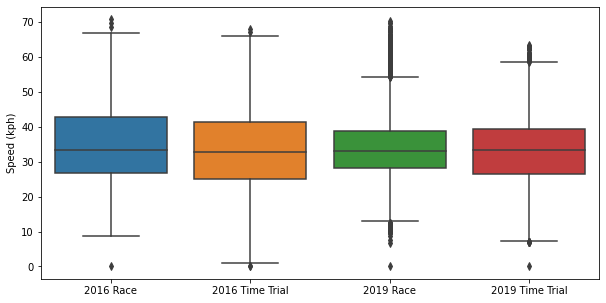

In [16]:
plt.subplots(figsize=(10,5))
bxclean = sns.boxplot(x='dataset',y='speed',data=df)
bxclean.set(xlabel = '',ylabel="Speed (kph)")
plt.show()

#### The data looks much better now and we can proceed with the analysis





---




# Section 1

What is the overall distance travelled for each of the rides? 
What are the average speeds etc. 
Provide a summary for each ride.

In [17]:
# Group by dataset
ds_grp = df.groupby('dataset')
ds_grp.head(2)

# Find average speed and total distance
mspeed = ds_grp.speed.mean()
sumdis = ds_grp.distance.sum()

# Merge into a dataframe
result = pd.concat([mspeed,sumdis], axis=1) 

# Rename columns
result.columns = ['ave speed (kph)','total distance (km)']

result

,ave speed (kph),total distance (km)
dataset,,
2016 Race,34.921239,49.048586
2016 Time Trial,33.472481,24.802887
2019 Race,33.879861,51.789133
2019 Time Trial,33.057824,24.380145


In [18]:
df.speed.mean()

33.89012302533313

### Initial Summary
- 2019's Race is slightly longer, covering 51.8km vs 49.1km in 2016.
- The average speed for all races is approximately 33.9 kph, but the 2016 Race was faster, at around 34.9 kph.
- Time Trial distance is approximately half of the distance covered in the race proper.

---

# Section 2


####  Compare the range of speeds for each ride, are time trials faster than road races?

We create a new column for moving averages to smoothen the lines

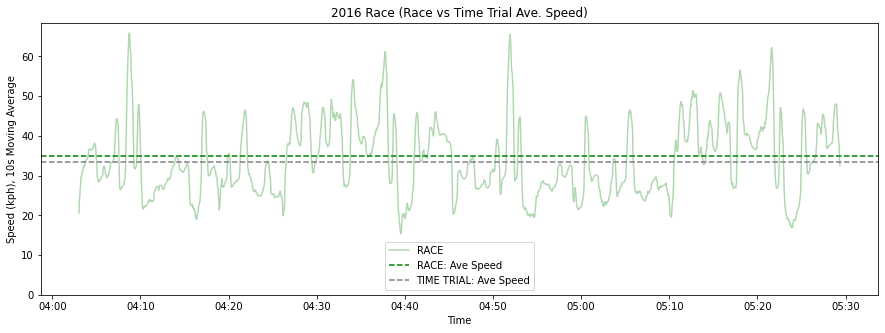

In [19]:
# line plot with reference line

df['speed_ma'] = df['speed'].rolling(10).mean()
# 2016

plt.figure(figsize=(15,5))

s2 = sns.lineplot(data=df.query('dataset == "2016 Race"'),
             x=df.query('dataset == "2016 Race"').index,
             y='speed_ma',
             alpha = .3,
             color = 'g',
             label = 'RACE',
             ci=None)
s2.set(xlabel='Time',ylabel='Speed (kph), 10s Moving Average',title="2016 Race (Race vs Time Trial Ave. Speed)")

s2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.axhline(y = df.query('dataset == "2016 Race"')['speed_ma'].mean(),
            color = 'green',
            linestyle="--",
            label = 'RACE: Ave Speed')
plt.axhline(y = df.query('dataset == "2016 Time Trial"')['speed_ma'].mean(),
            color = 'gray',
            linestyle="--",
            label = 'TIME TRIAL: Ave Speed')

plt.legend(loc='lower center')
plt.ylim(0,None)
plt.show()

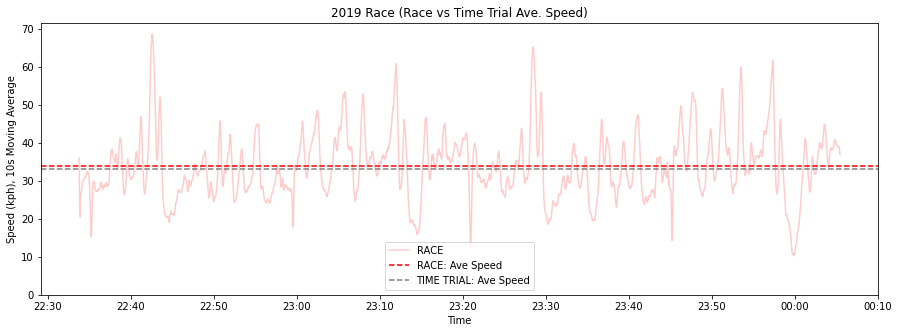

In [20]:

plt.figure(figsize=(15,5))

s2_3 = sns.lineplot(data=df.query('dataset == "2019 Race"'),
             x=df.query('dataset == "2019 Race"').index,
             y='speed_ma',
             alpha = .2,
             color = 'r',
             label = 'RACE',
             ci=None)
s2_3.set(xlabel='Time',ylabel='Speed (kph), 10s Moving Average',title="2019 Race (Race vs Time Trial Ave. Speed)")

s2_3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.axhline(y = df.query('dataset == "2019 Race"')['speed_ma'].mean(),
            color = 'r',
            linestyle="--",
            label = 'RACE: Ave Speed')
plt.axhline(y = df.query('dataset == "2019 Time Trial"')['speed_ma'].mean(),
            color = 'gray',
            linestyle="--",
            label = 'TIME TRIAL: Ave Speed')

plt.legend(loc='lower center')
plt.ylim(0,None)
plt.show()

In both cases, the average speed of the race is faster than the time trial. We would have already seen this from the boxplot earlier, the purpose of the line plots is to give a bit more context.

---

# Section 3

Compare the speeds achieved in the two time trials (three years apart). As well as looking at the averages, can you see where in the ride one or the other is faster.

To have a uniform X values, create a new column to calculate cumulative distance traveled.

In [49]:
# df['cumdis'] = df
df3 = df.copy(deep=True)
df3['cumdis'] = df3['distance'].groupby(df3['dataset']).transform('cumsum')
df3.query('dataset=="2019 Race"')

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset,speed_ma,cumdis
2019-06-22 22:33:45+00:00,-33.416592,151.222853,215.0,0.0,0.0,58.0,71.0,0.000000,0.0,0.000000,NaN,2019 Race,35.964525,0.000000
2019-06-22 22:33:46+00:00,-33.416629,151.222877,215.0,0.0,147.0,58.0,71.0,0.004679,0.0,16.842677,1.0,2019 Race,33.184950,0.004679
2019-06-22 22:33:47+00:00,-33.416677,151.222905,214.8,0.0,97.0,60.0,71.0,0.005936,-0.2,21.371074,1.0,2019 Race,30.823209,0.010615
2019-06-22 22:33:48+00:00,-33.416730,151.222937,214.8,0.0,74.0,61.0,71.0,0.006599,0.0,23.757913,1.0,2019 Race,28.751570,0.017214
2019-06-22 22:33:49+00:00,-33.416783,151.222972,214.8,0.0,136.0,62.0,71.0,0.006729,0.0,24.225566,1.0,2019 Race,26.724033,0.023944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-23 00:05:23+00:00,-33.415728,151.222289,216.6,7.0,28.0,23.0,153.0,0.010218,-0.2,36.786246,1.0,2019 Race,38.510606,51.750079
2019-06-23 00:05:24+00:00,-33.415808,151.222340,216.6,7.0,13.0,10.0,153.0,0.010077,0.0,36.275739,1.0,2019 Race,38.235780,51.760155
2019-06-23 00:05:25+00:00,-33.415885,151.222391,216.6,7.0,0.0,0.0,152.0,0.009783,0.0,35.220093,1.0,2019 Race,37.835513,51.769939
2019-06-23 00:05:26+00:00,-33.415962,151.222440,216.6,7.0,0.0,0.0,152.0,0.009695,0.0,34.901660,1.0,2019 Race,37.438904,51.779633


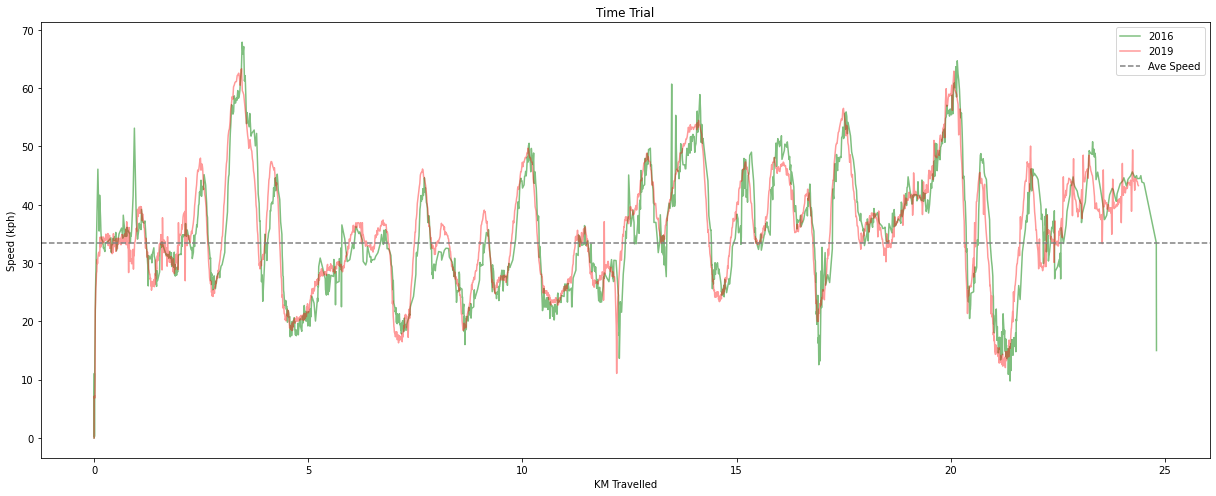

In [123]:
plt.figure(figsize=(17,7))

ax3 = plt.plot(df3.query('dataset=="2016 Time Trial"').cumdis, df3.query('dataset=="2016 Time Trial"').speed, 
         label = '2016',
         c='g',
         alpha = .5)
plt.plot(df3.query('dataset=="2019 Time Trial"').cumdis, df3.query('dataset=="2019 Time Trial"').speed,
         label = '2019',
         c='r',
         alpha = .4)
plt.axhline(y = df.query('dataset == "2016 Time Trial"')['speed'].mean(),
            color = 'gray',
            linestyle="--",
            label = 'Ave Speed')

plt.title("Time Trial")
plt.xlabel("KM Travelled")
plt.ylabel("Speed (kph)")
plt.legend()
plt.show()
# try joinplot to show 

The time trial speeds between the 2016 and 2019 Race are very identical and almost tracks each other perfectly

---

# Section 4

From the elevation_gain field you can see whether the rider is climbing , descending or on the flat. Use this to calculate the average speeds in those three cases (climbing, flat or descending). Note that flat might not be zero elevation_gain but might allow for slight climbs and falls.

To see this, I will check how the speed varies between different elevation levels.

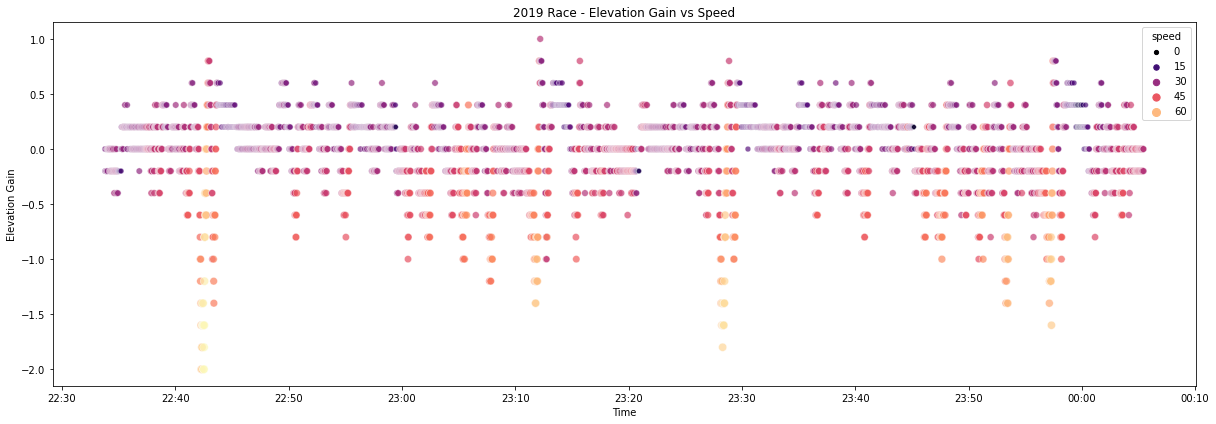

In [121]:
plt.figure(figsize=(17,6))
el_ax = sns.scatterplot(data=df.query('dataset=="2019 Race"'),
                        x = df.query('dataset == "2019 Race"').index,
                        y = 'elevation_gain',
                        hue = 'speed',
                        palette = 'magma',
                        linewidths=0,
                        alpha=.7,
                        size='speed'
                       )

sns.color_palette("flare", as_cmap=True)
el_ax.set(xlabel = 'Time',ylabel = 'Elevation Gain',title = '2019 Race - Elevation Gain vs Speed')
el_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

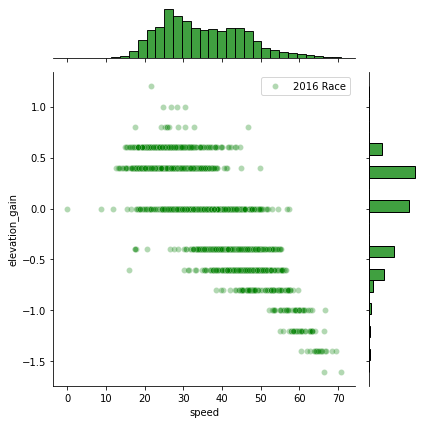

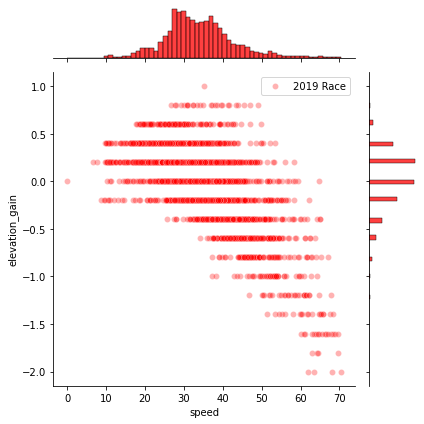

In [120]:
axx = sns.jointplot(data=df.query('dataset=="2016 Race"'),
              x='speed',y='elevation_gain',color='g',label="2016 Race",alpha = .3)
axx2 = sns.jointplot(data=df.query('dataset=="2019 Race"'),
              x='speed',y='elevation_gain',color='r',label="2019 Race",alpha = .3)

Since elevation gains between -0.3 and 0.3 doesn't vary the speed range very much, this elevation gain range will be considered __flat__.

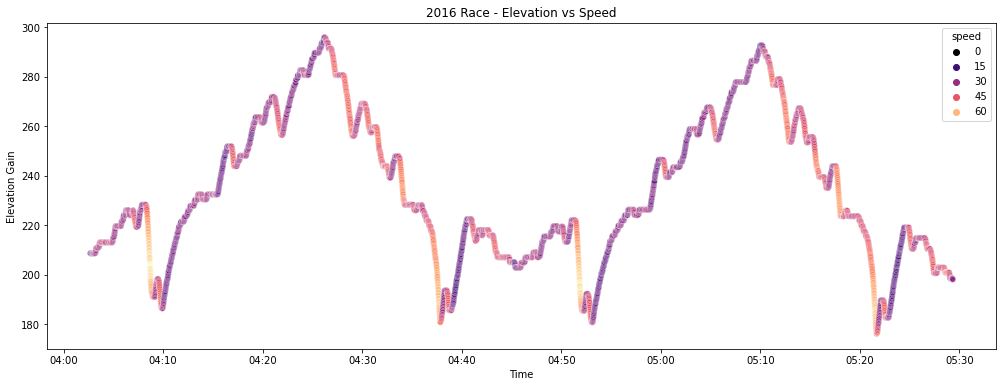

In [22]:
plt.figure(figsize=(17,6))
el_ax2 = sns.scatterplot(data=df.query('dataset=="2016 Race"'),
                        x = df.query('dataset == "2016 Race"').index,
                        y = 'elevation',
                        hue = 'speed',
                        palette = 'magma',
                        linewidths=0,
                        alpha=.7
                       )

sns.color_palette("flare", as_cmap=True)
el_ax2.set(xlabel = 'Time',ylabel = 'Elevation Gain',title = '2016 Race - Elevation vs Speed')
el_ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

In [135]:
conditions = [(df['elevation_gain'] < -.3),
              (df['elevation_gain'] >= -.3) & (df['elevation_gain'] <= .3),
              (df['elevation_gain'] > .3) ]

state = ['downhill','flat','uphill']

df['elev_state'] = np.select(conditions,state)
df.sample(n=5)

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dataset,speed_ma,elev_state
2016-05-14 04:21:44+00:00,-33.334566,151.230956,258.6,26.0,0.0,103.0,165.0,0.013124,-0.4,47.246259,1.0,2016 Race,44.520656,downhill
2019-06-22 22:38:27+00:00,-33.408876,151.216733,221.8,5.0,384.0,93.0,144.0,0.010108,0.0,36.388491,1.0,2019 Race,33.839241,flat
2016-05-14 04:53:28+00:00,-33.384186,151.224279,189.0,25.0,0.0,75.0,145.0,0.006402,0.6,23.046012,1.0,2016 Race,22.113405,uphill
2019-06-22 22:41:11+00:00,-33.396827,151.214360,225.2,5.0,0.0,0.0,128.0,0.013264,-0.4,47.750585,1.0,2019 Race,46.098395,downhill
2019-06-22 22:50:31+00:00,-33.357483,151.227500,257.0,6.0,12.0,17.0,117.0,0.010842,-0.4,39.029817,1.0,2019 Race,34.120612,downhill


In [145]:
gg = df.groupby(['dataset','elev_state'])['speed'].mean()
ggu = gg.unstack()
# print(gg)
ggu

elev_state,downhill,flat,uphill
dataset,,,
2016 Race,45.927927,34.420323,26.337181
2016 Time Trial,44.913178,34.033660,24.575338
2019 Race,46.061209,32.699969,27.530555
2019 Time Trial,47.712952,32.019392,23.306943


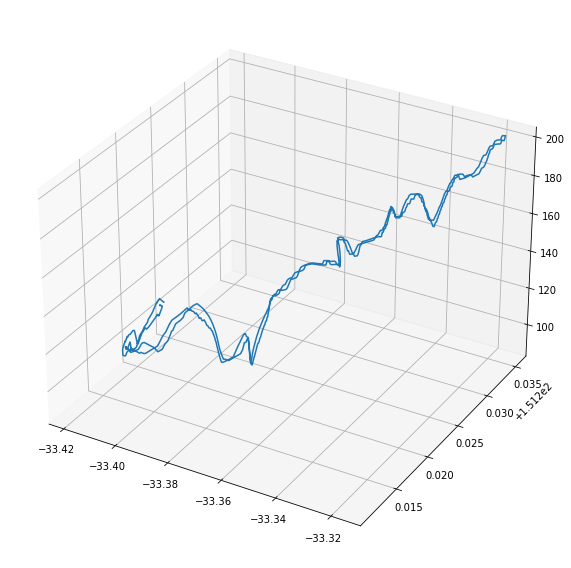

In [127]:
# # Experiment on 3D plot to account for elevation
# # %matplotlib notebook

# fig = plt.figure(figsize=(12,8))

# ax3d = plt.axes(projection='3d')
# xdata = df.query('dataset=="2016 Time Trial"')['latitude']
# ydata = df.query('dataset=="2016 Time Trial"')['longitude']
# zdata = df.query('dataset=="2016 Time Trial"')['elevation']
# ax3d.plot3D(xdata,ydata,zdata)
# # ax3d.view_init(20,45)

---

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





## Redo variables for histogram, use clean data

In [24]:
# calculate development for each race

rr_2016['dev'] = rr_2016['cadence'] / rr_2016['speed']
tt_2016['dev'] = tt_2016['cadence'] / tt_2016['speed']
rr_2019['dev'] = rr_2019['cadence'] / rr_2019['speed']
tt_2019['dev'] = tt_2019['cadence'] / tt_2019['speed']
rr_2016.sample(n=10)

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dev
2016-05-14 04:55:06+00:00,-33.379095,151.225006,214.8,25.0,0.0,95.0,171.0,0.007527,0.4,27.096398,1.0,3.506001
2016-05-14 04:37:28+00:00,-33.383226,151.224927,203.4,25.0,0.0,0.0,172.0,0.015733,-0.8,56.637298,1.0,0.000000
2016-05-14 04:29:33+00:00,-33.336745,151.230905,262.4,25.0,0.0,82.0,142.0,0.016524,0.0,29.742907,2.0,2.756960
2016-05-14 04:22:16+00:00,-33.331563,151.231081,262.2,26.0,0.0,85.0,157.0,0.008342,0.4,30.030081,1.0,2.830495
2016-05-14 04:39:09+00:00,-33.392630,151.221996,188.6,25.0,0.0,75.0,152.0,0.005872,0.4,21.137857,1.0,3.548136
2016-05-14 04:33:26+00:00,-33.359127,151.227106,247.8,24.0,0.0,74.0,151.0,0.025258,0.0,30.309995,3.0,2.441439
2016-05-14 05:20:37+00:00,-33.378480,151.225319,215.8,24.0,0.0,91.0,144.0,0.013213,-0.4,47.565222,1.0,1.913163
2016-05-14 04:36:53+00:00,-33.378924,151.225088,218.6,25.0,0.0,41.0,138.0,0.011765,-0.6,42.355324,1.0,0.968001
2016-05-14 04:37:23+00:00,-33.382568,151.225155,206.2,25.0,0.0,0.0,172.0,0.014014,-0.4,50.451196,1.0,0.000000
2016-05-14 05:17:48+00:00,-33.361682,151.227989,236.8,24.0,0.0,30.0,168.0,0.014311,-0.8,51.521050,1.0,0.582286


In [25]:
# filter development between 2 and 10

rr16 = rr_2016.query('dev>=2 & dev<=10').copy(deep=True)
tt16 = tt_2016.query('dev>=2 & dev<=10').copy(deep=True)
rr19 = rr_2019.query('dev>=2 & dev<=10').copy(deep=True)
tt19 = tt_2019.query('dev>=2 & dev<=10').copy(deep=True)
rr16

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,dev
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0,3.396445
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2.442743
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2.588978
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2.606702
2016-05-14 04:02:52+00:00,-33.415104,151.221976,208.6,29.0,0.0,62.0,109.0,0.007111,0.0,25.599979,1.0,2.421877
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-14 05:28:40+00:00,-33.413164,151.220644,200.8,24.0,0.0,104.0,169.0,0.026567,0.0,47.820718,2.0,2.174790
2016-05-14 05:28:44+00:00,-33.413602,151.220923,200.8,24.0,0.0,103.0,180.0,0.055160,0.0,49.643892,4.0,2.074777
2016-05-14 05:28:45+00:00,-33.413709,151.220986,200.8,24.0,0.0,102.0,180.0,0.013257,0.0,47.725651,1.0,2.137215
2016-05-14 05:28:54+00:00,-33.414636,151.221582,200.8,24.0,0.0,92.0,185.0,0.063469,0.0,45.697454,5.0,2.013241


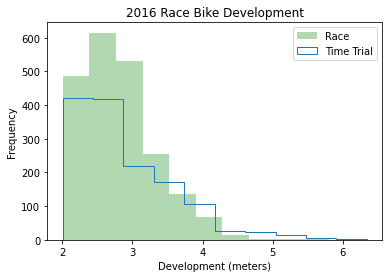

In [26]:
hist = rr16['dev'].plot.hist(color='g',alpha=.3,rwidth=10,label='Race')
tt16['dev'].plot.hist(histtype='step',label='Time Trial')
hist.set(xlabel='Development (meters)',title='2016 Race Bike Development')
plt.legend()
plt.show()

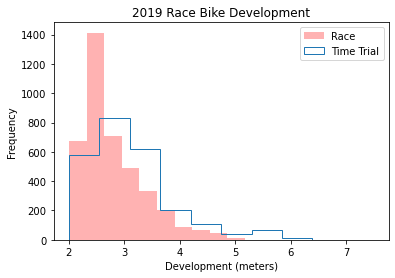

In [27]:
hist2 = rr19['dev'].plot.hist(color='r',alpha=.3,rwidth=10,label='Race')
tt19['dev'].plot.hist(histtype='step',label='Time Trial')
hist2.set(xlabel='Development (meters)',title='2019 Race Bike Development')
plt.legend()
plt.show()

### Race Analysis

In the 2016 race, the __development__ are mostly within __2-3m__. It can also be seen that the race has a higher frequency in almost all levels of development, indicating that the distance travelled in the race may be longer than during the time trial. In a few instances during the time trial, the rider was able to get a development of about 5m, but not during the race. This indicates that the rider may have a higher top speed during the time trial compared to the race.


